In [1]:



# # Preprocessing section
#
# Clean raw data and convert it to useful format.
#

In [2]:




import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [3]:




from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_squared_error

In [4]:




plt.rcParams['figure.figsize'] = (20, 10)

In [5]:







# #### Utility functions

In [6]:




def is_na(s):
    return s.isna()

def not_na(s):
    return ~s.isna()

In [7]:




def calc_rmse(*args):
    mse = mean_squared_error(*args)
    return np.sqrt(mse)

In [8]:




def centered_ma(series, order):
    shift_by = order//2

    if order%2 == 0:
        ma = series.rolling(order).mean().shift(-order+2)
        ma = ma.rolling(order//2).mean()

    else:
        ma = series.rolling(order).mean().shift(-shift_by)

    return ma

In [9]:




def adf(signal):
    stats = adfuller(signal)

    print( 'ADF stats: {:.4f}'.format(stats[0]) )
    print( 'p-value:{}'.format(stats[1]) )
    print( 'Used lag:{}'.format(stats[2]) )
    print('Critical values:')
    for level, val in stats[4].items():
        print( ' {}: {:.4f}'.format(level, val) )

In [10]:




def downsampling_plot(series, series_downsampled):
    plt.plot(series, label='Original')
    plt.plot(series_downsampled, label='Downsampled')

    plt.legend(loc='best')

In [11]:







# ### Data loading and exploration

In [12]:




filename = 'brandon_river_data_station_20002.txt'
df = pd.read_csv(filename, skiprows=6,
                 sep='\t', low_memory=False,
                 index_col='Date', parse_dates=True)

In [13]:




print('Dataframe shape:', df.shape)
df.head()

Dataframe shape: (1551546, 2)


,Value,Quality
Date,,
1975-01-01 00:00:00,7.595,31
1975-01-01 00:15:00,7.595,31
1975-01-01 00:30:00,7.594,31
1975-01-01 00:45:00,7.594,31
1975-01-01 01:00:00,7.593,31


In [14]:




df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1551546 entries, 1975-01-01 00:00:00 to 2020-03-01 00:00:00
Data columns (total 2 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   Value    1551546 non-null  float64
 1   Quality  1551546 non-null  object 
dtypes: float64(1), object(1)
memory usage: 35.5+ MB


In [15]:




df.describe()

,Value
count,1.551546e+06
mean,7.465871e+00
std,2.801594e-01
min,6.981000e+00
25%,7.257000e+00
50%,7.419000e+00
75%,7.621000e+00
max,1.016800e+01


In [16]:




# Date range
start_date = df.index.min()
end_date = df.index.max()
print('Start date:', start_date)
print('End date:', end_date)

Start date: 1975-01-01 00:00:00
End date: 2020-03-01 00:00:00


In [17]:




number_of_years = df.index.year.value_counts().shape[0]
print('The data is for about {0} years, between 1975 and 2020.'.format(number_of_years, start_date.year, end_date.year))


# Sampling period is 15 mins

The data is for about 46 years, between 1975 and 2020.


In [18]:




df.shape[0] / (4 * 24 * 365)

44.27928082191781

In [19]:







# ## Visualizing the time-series

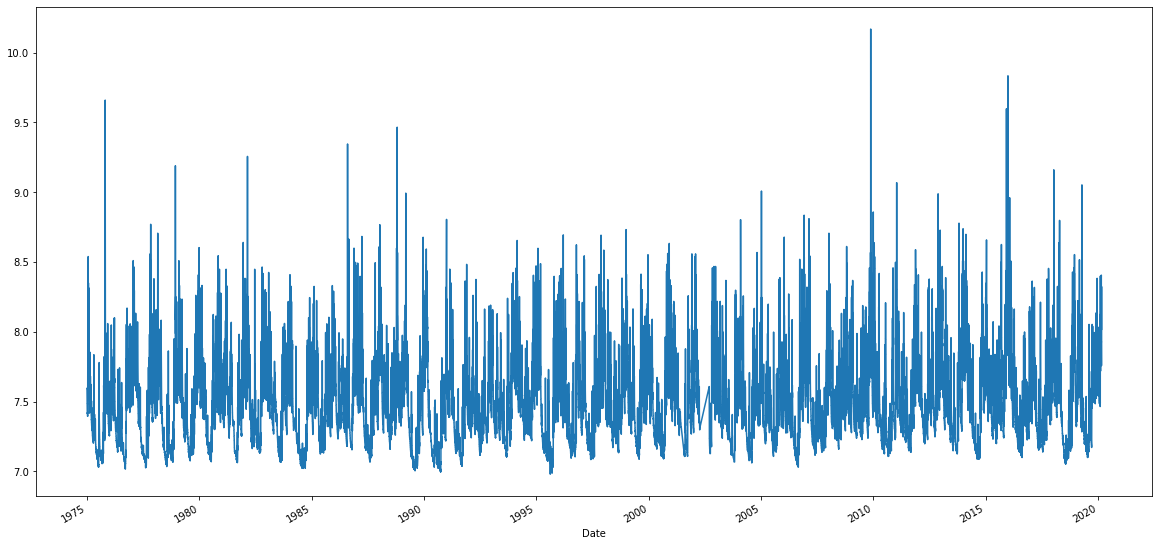

In [20]:




series = df.Value
series.plot()


# Taking the first 16 years of measurements as sample.

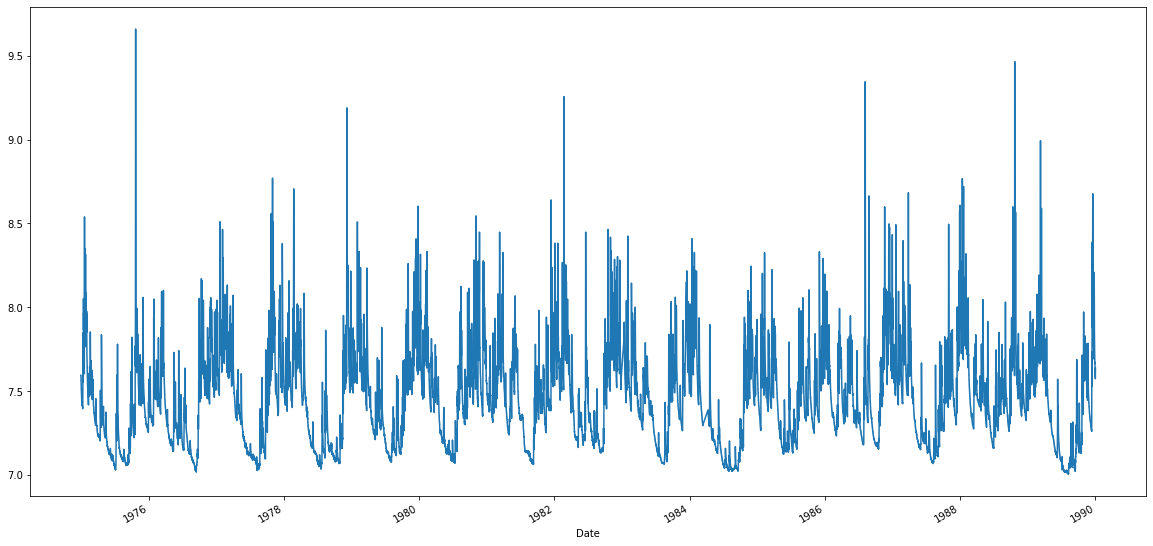

In [21]:




series_sample = series[:'1989']
series_sample.plot()


# ### Downsampling and assessing the information loss
#
# The original series, sampled at 15 mins, will be down-sampled to hourly period and aggregated using mean value. The series lenght is expected to be divided by a factor of 4 (60 mins / 15 mins).

In [22]:




# Down-sample to hourly, with mean value
series_hourly = series.resample('60T').mean()

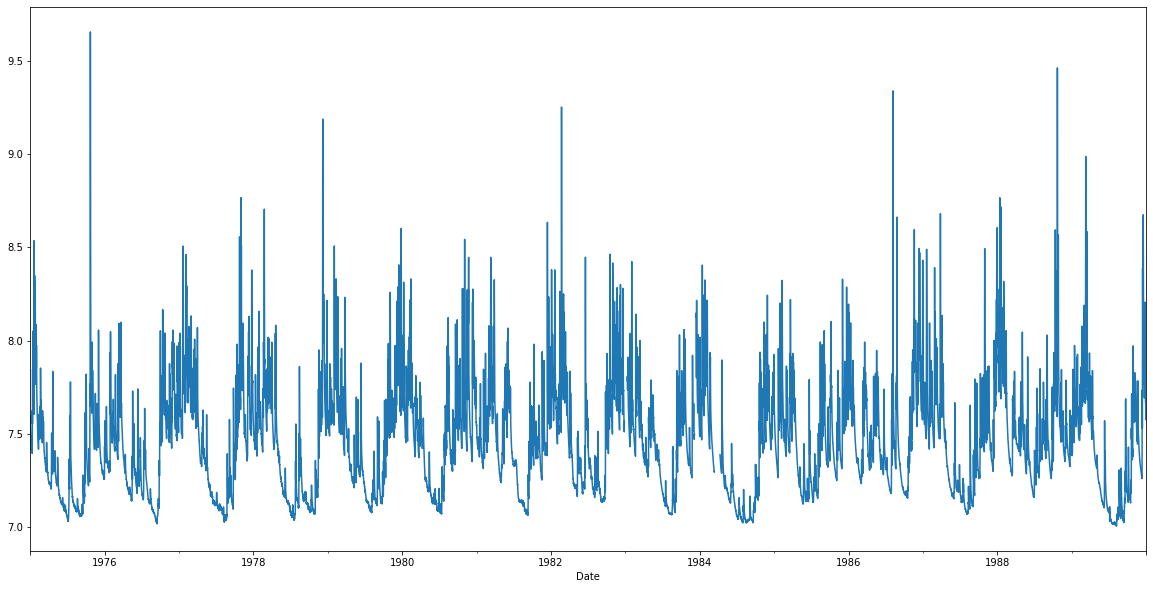

In [23]:




series_hourly_sample = series_hourly[:'1989']
series_hourly_sample.plot()

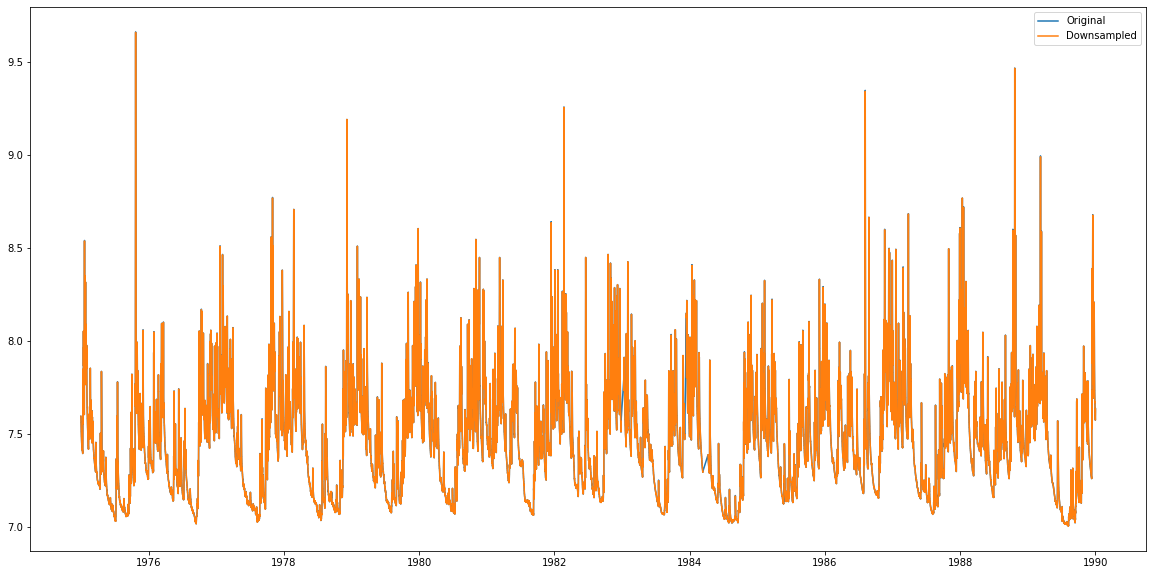

In [24]:




downsampling_plot(series_sample, series_hourly_sample)


# Zooming out to assess a window of 6 months.

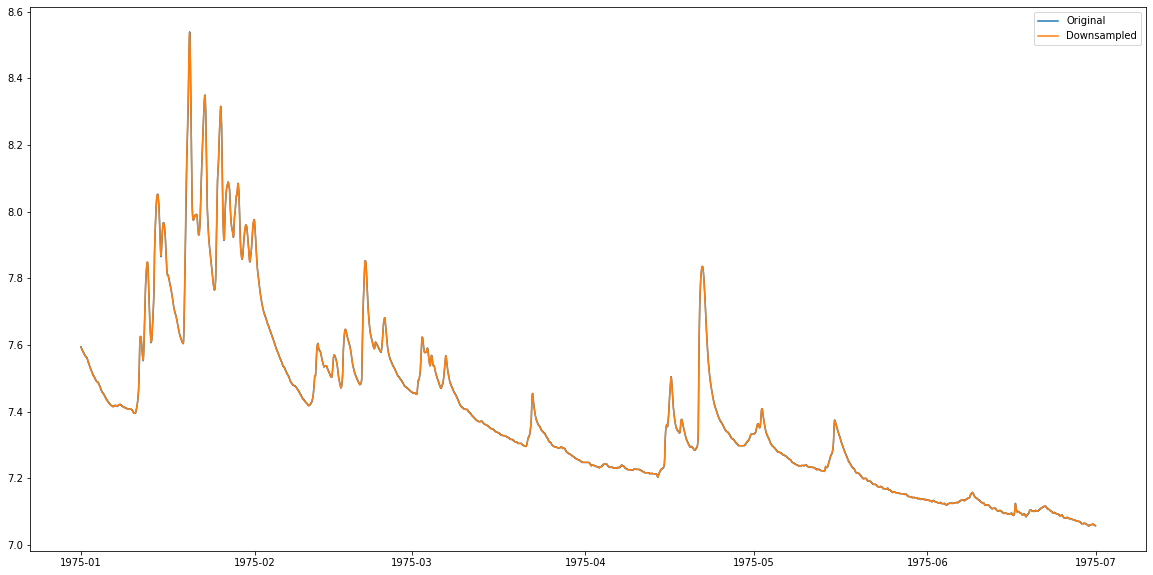

In [25]:




downsampling_plot(series_sample[:'1975-06'],
                  series_hourly_sample[:'1975-06'])


# Measure the correlation and loss

In [26]:




s1 = series_sample[:'1975-06']

# Upsample the hourly to 15 minutes to match the dimension of the original series
s2 = series_hourly_sample[:'1975-06'].resample('15T').bfill()

s1 = s1.values[:len(s2)]
s2 = s2.values

In [27]:




corr = np.corrcoef(s1, s2)
print('Correlation:', corr[0][1])

Correlation: 0.9997292712368465


In [28]:




error = calc_rmse(s1, s2)
print('RMSE:', error)

RMSE: 0.006012895302405344


In [29]:







# ### Time-series decomposition
# The series decomposed into its components:
# - Trend
# - Seasonality
# - Residual

In [30]:



# #### Using the first gapless data of 7 years

In [31]:




series_gapless = series_hourly[:'1981']
series_gapless.shape

(61368,)

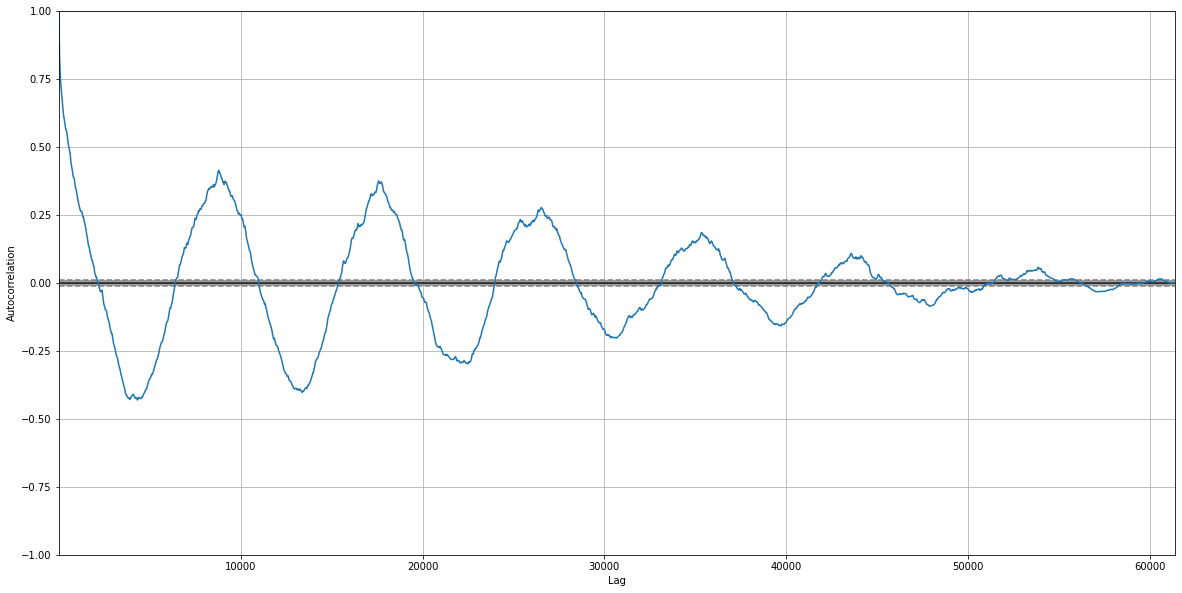

In [32]:




pd.plotting.autocorrelation_plot(series_gapless)



#
# Specifying a periodicity of 8760 hours.

In [33]:




period = 24 * 365
period


# The additive decomposition model:
#
# Y[t] = T[t] + S[t] + e[t]
#

8760

In [34]:




d = seasonal_decompose(series_gapless,
                       period=period,
                       model='additive')

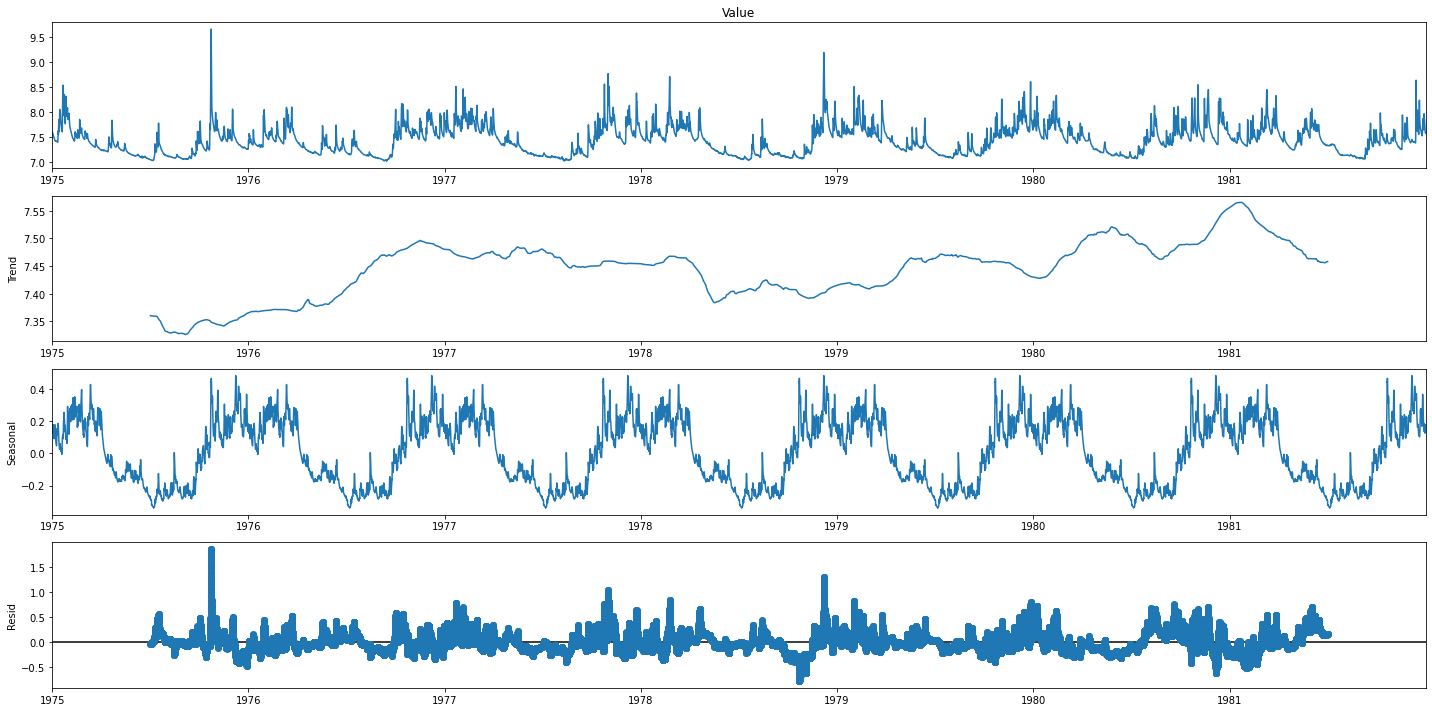

In [35]:




d.plot()
plt.show()

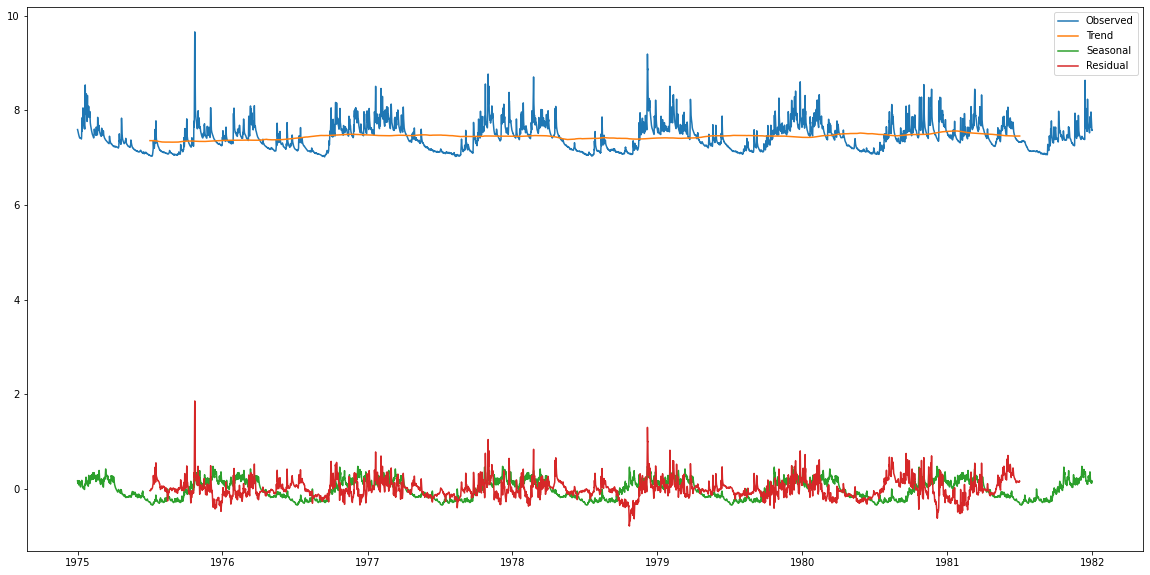

In [36]:




plt.plot(d.observed, label='Observed')
plt.plot(d.trend, label='Trend')
plt.plot(d.seasonal, label='Seasonal')
plt.plot(d.resid, label='Residual')
plt.legend()


# This shows a quasi linear trend and a yearly seasonality.

In [37]:




# Experiment to measure the seasonality correlation of the series and a year lag
y = d.seasonal
y = y[~y.isna()]

y_lag = y.shift(-period)

np.corrcoef(y[:-period], y_lag[:-period])[0, 1]

1.0

In [38]:







# ### Stationarity
#
# Augmented Dickey-Fuller (ADF) Test

In [39]:




adf(series_hourly['1975': '1979'])


# The ADF statistic value is less than the critical value at 1%. Therefore, we reject the null hypothesis with a significance level of less than 1%. That is, the time series process has no unit root and the series is stationary, with no linear time-dependent structure.

ADF stats: -7.4601
p-value:5.3826235375691425e-11
Used lag:40
Critical values:
 1%: -3.4305
 5%: -2.8616
 10%: -2.5668


In [40]:




adf(d.resid.dropna())

ADF stats: -11.1489
p-value:2.978460387362578e-20
Used lag:57
Critical values:
 1%: -3.4305
 5%: -2.8616
 10%: -2.5668


In [41]:







# ### Seasonal adjustment and imputing the gaps

In [42]:




# Peek gaps
missing_values = series_hourly[is_na]
missing_values

Date
1982-12-27 03:00:00   NaN
1982-12-27 04:00:00   NaN
1982-12-27 05:00:00   NaN
1982-12-27 06:00:00   NaN
1982-12-27 07:00:00   NaN
                       ..
2019-09-22 09:00:00   NaN
2019-09-22 10:00:00   NaN
2019-09-22 11:00:00   NaN
2019-09-22 12:00:00   NaN
2019-09-22 13:00:00   NaN
Name: Value, Length: 7965, dtype: float64

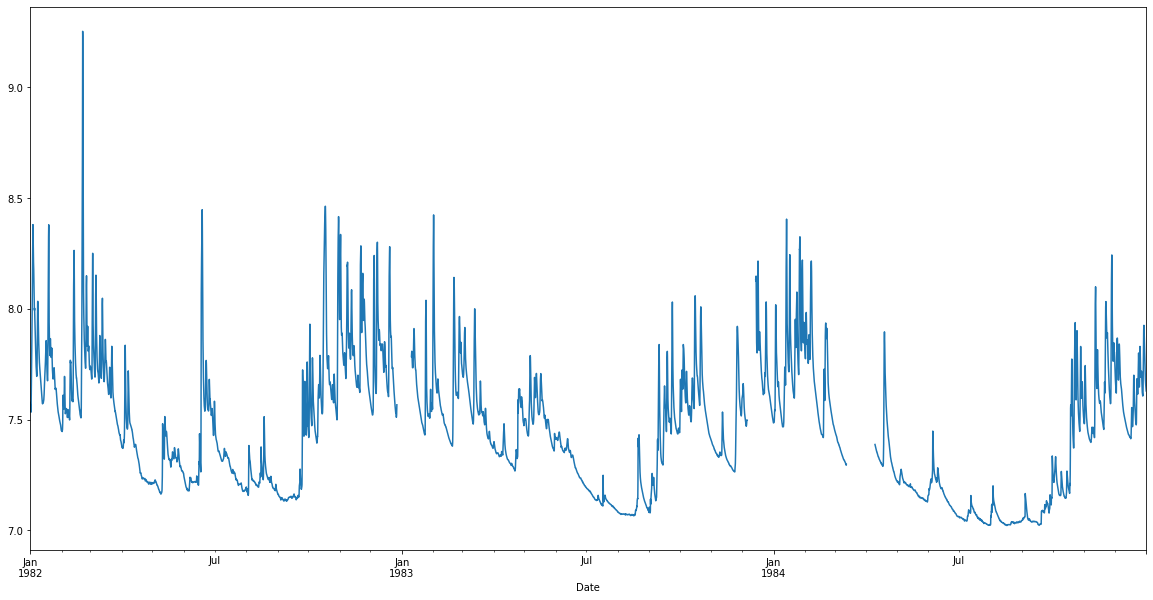

In [43]:




# Example gap
series_hourly['1982':'1984'].plot()


# There are gaps in the original series. Downsampling contracts the gap, but still it is still wide.
#
# There are two ways to handle the missing values:
# - leave out the gaps with no values
# - missing values imputating
#
# Because of the temporal structure of time series, appropriate statistical techniques rather than for the static data such as: mean, median, and mode.
#
# Combining seasonal adjustment with an interpolation proves effective when seasonality is present.

# Manual decomposition through differencing

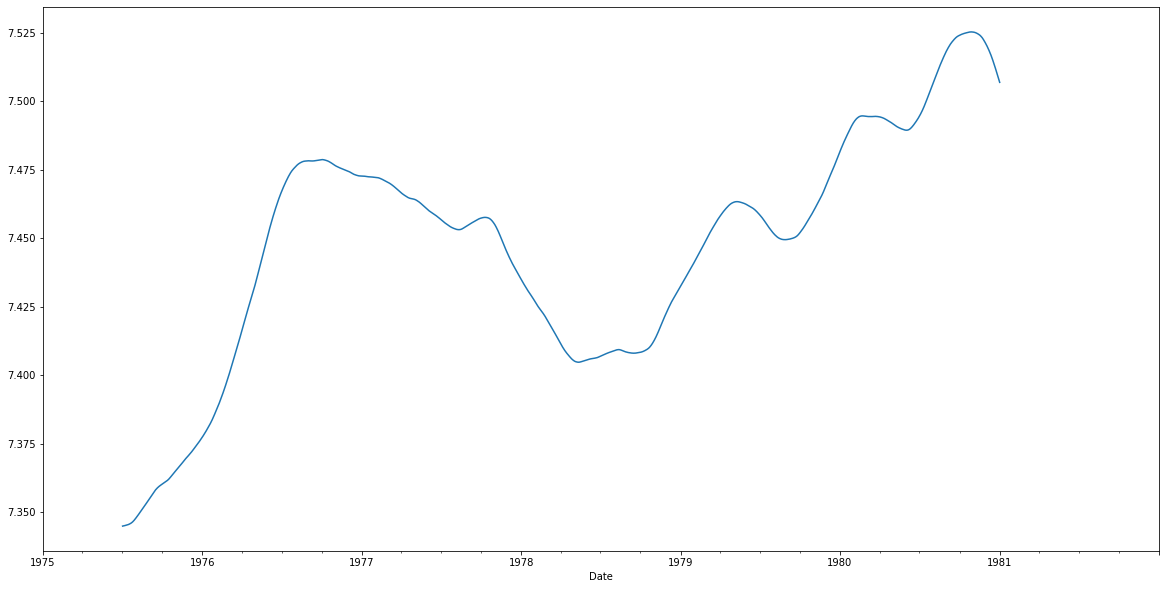

In [44]:




# Trend component
s_trend = centered_ma(series_gapless, period)
s_trend.plot()

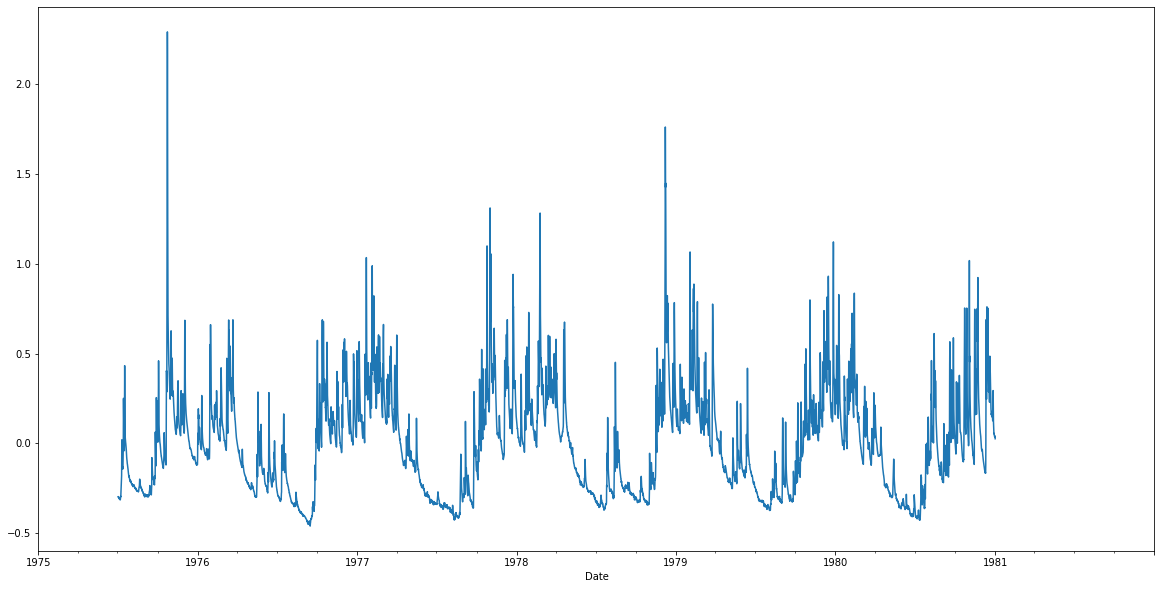

In [45]:




# Remove the trend component
s_detrend = series_gapless - s_trend
s_detrend.plot()

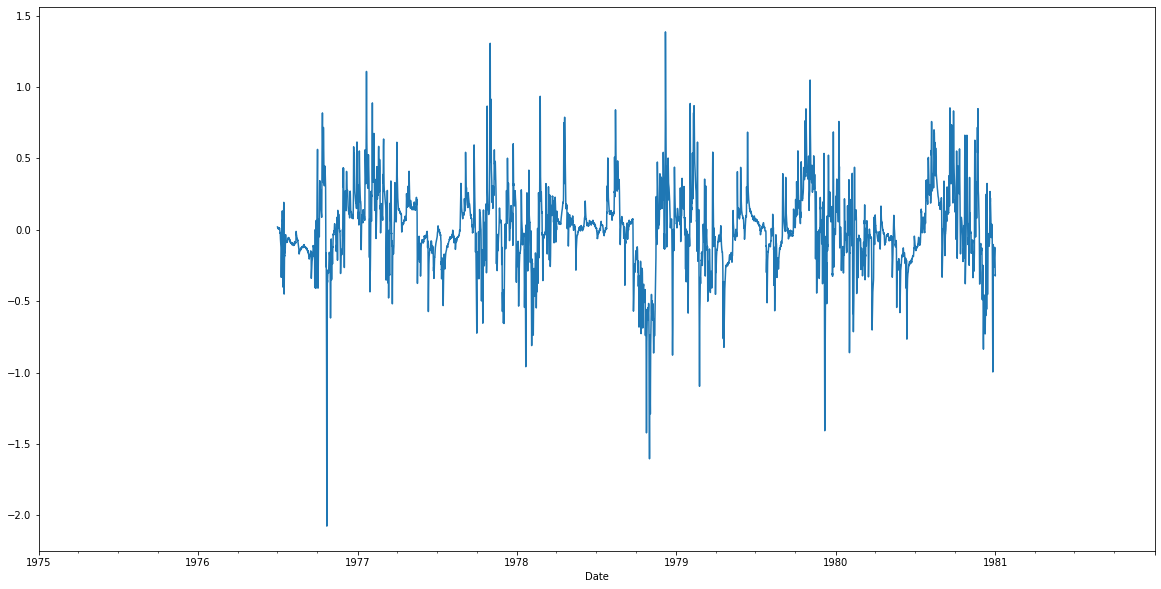

In [46]:




# Remove the seasonal component
s_resid = s_detrend - s_detrend.shift(period)
s_resid.plot()

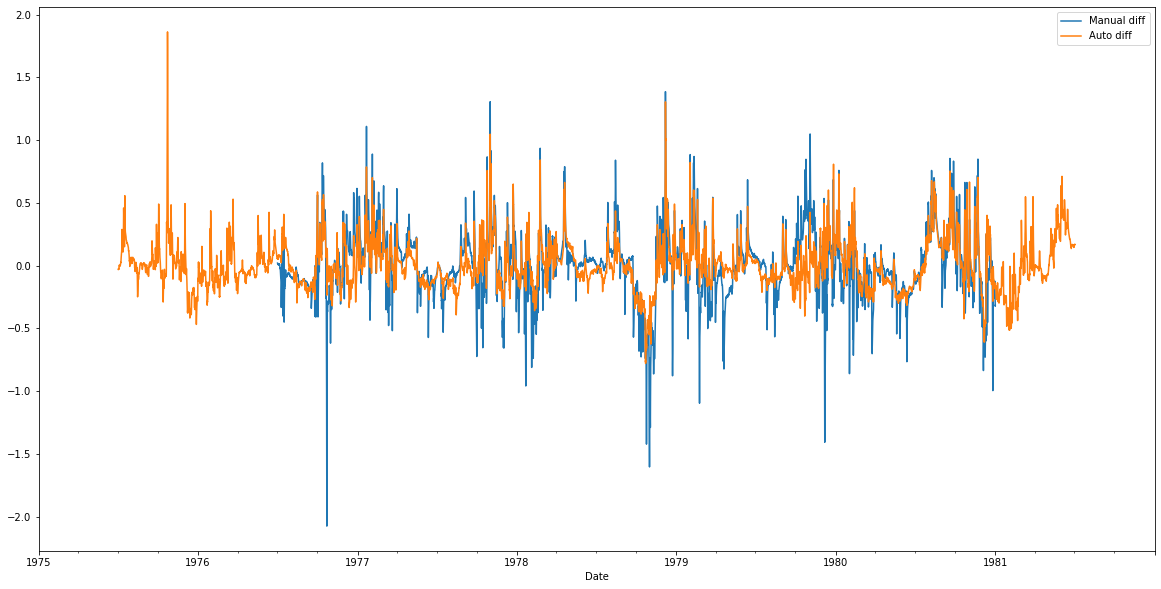

In [47]:




s_resid.plot(label='Manual diff')
d.resid.plot(label='Auto diff')
plt.legend()


# ### Get the seasonal component
#
# Deseasonalize the series, interpolate, then seasonalize.

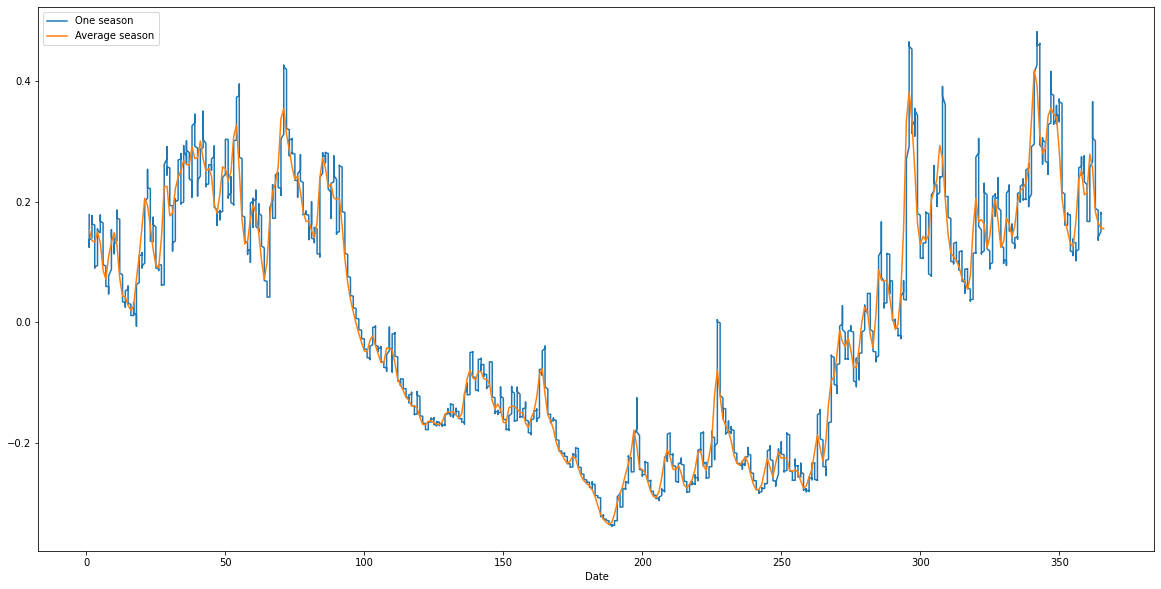

In [48]:




plt.plot(d.seasonal[:'1975'].index.dayofyear, d.seasonal[:'1975'].values, label='One season')

season_pattern = d.seasonal.groupby(d.seasonal.index.dayofyear).mean()
season_pattern.plot(label='Average season')

plt.legend()

In [49]:




df_hourly = pd.DataFrame()
df_hourly['Values'] = series_hourly
df_hourly.shape

(395905, 1)

In [50]:




df_hourly['Seasonal'] = df_hourly.apply(lambda r: season_pattern[r.index.dayofyear]).values

In [51]:




df_hourly['Deseasoned'] = df_hourly.Values - df_hourly.Seasonal


# Interpolate the deseasonalized series.

In [52]:




df_hourly['Interpolated'] = df_hourly.Deseasoned.interpolate(method='linear')

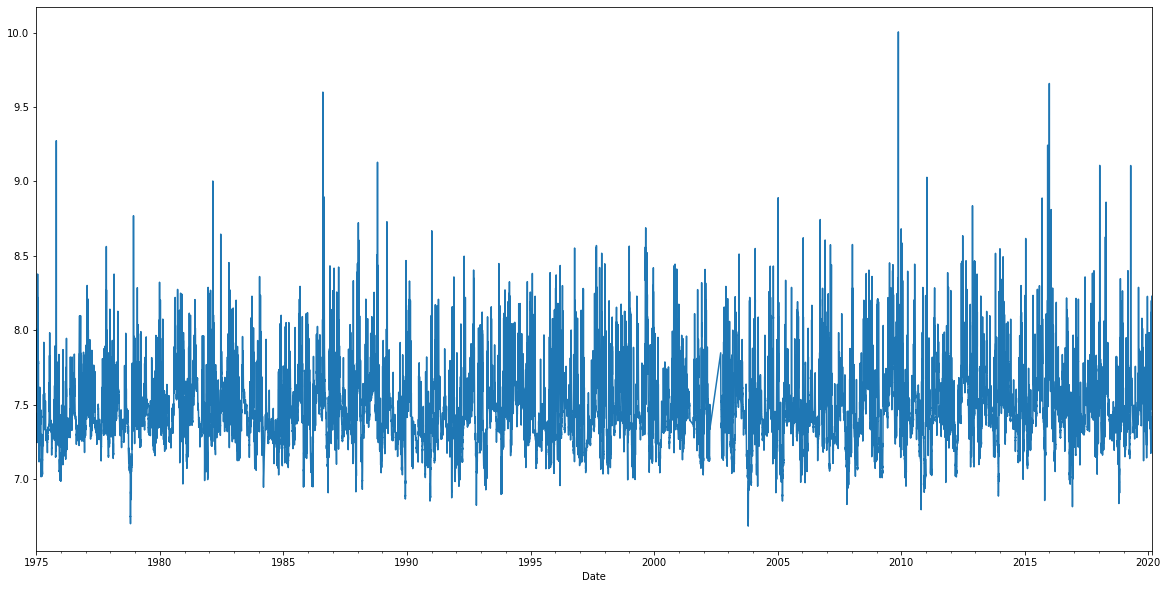

In [53]:




df_hourly.Interpolated.plot()


# Add the seasonal component to the interpolated series.

In [54]:




series_hourly_int = df_hourly.Interpolated + df_hourly.Seasonal

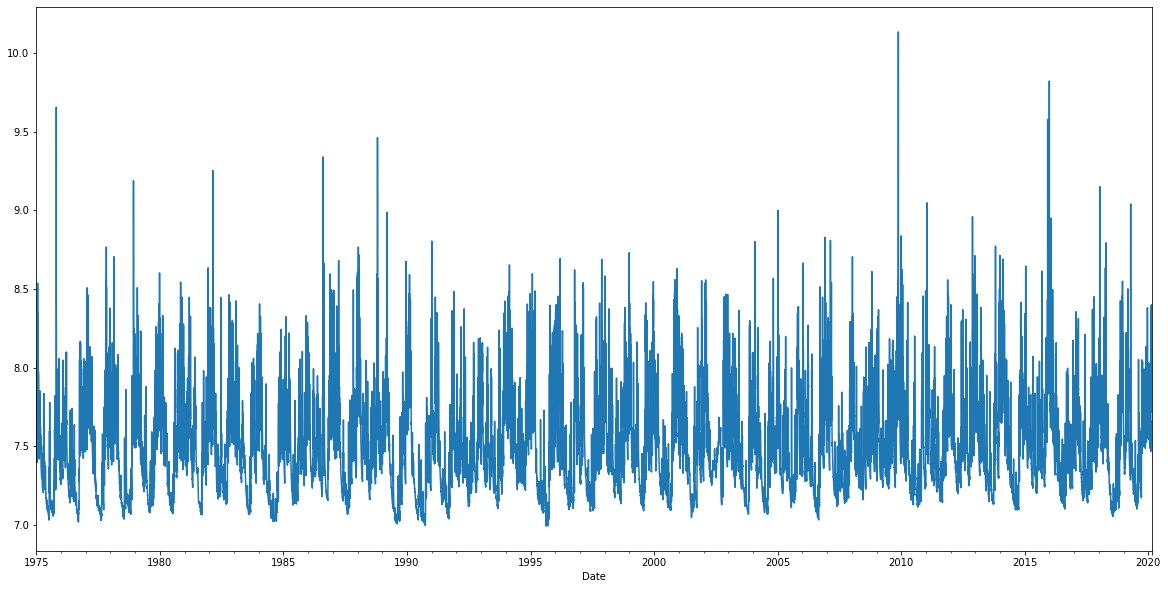

In [55]:




series_hourly_int.plot()

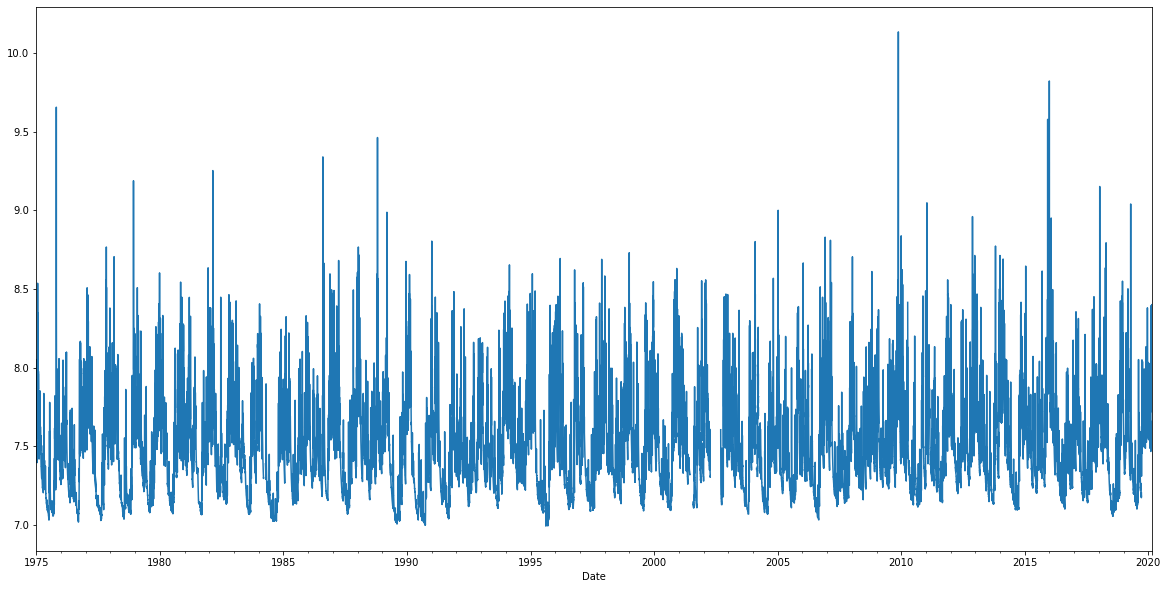

In [56]:




series_hourly.plot()

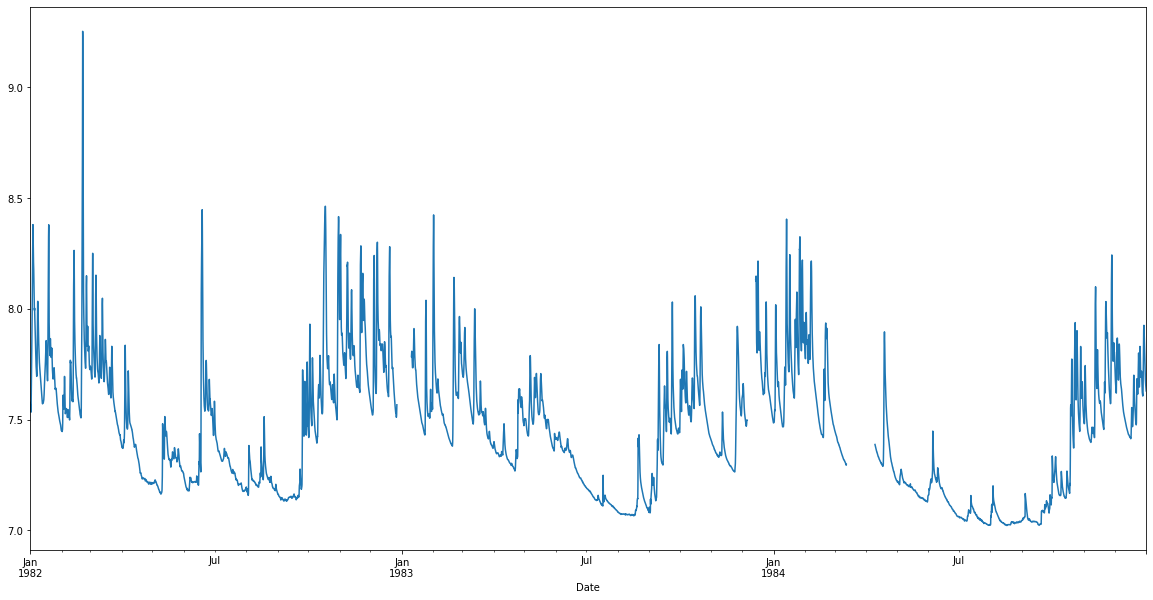

In [57]:




series_hourly['1982':'1984'].plot()

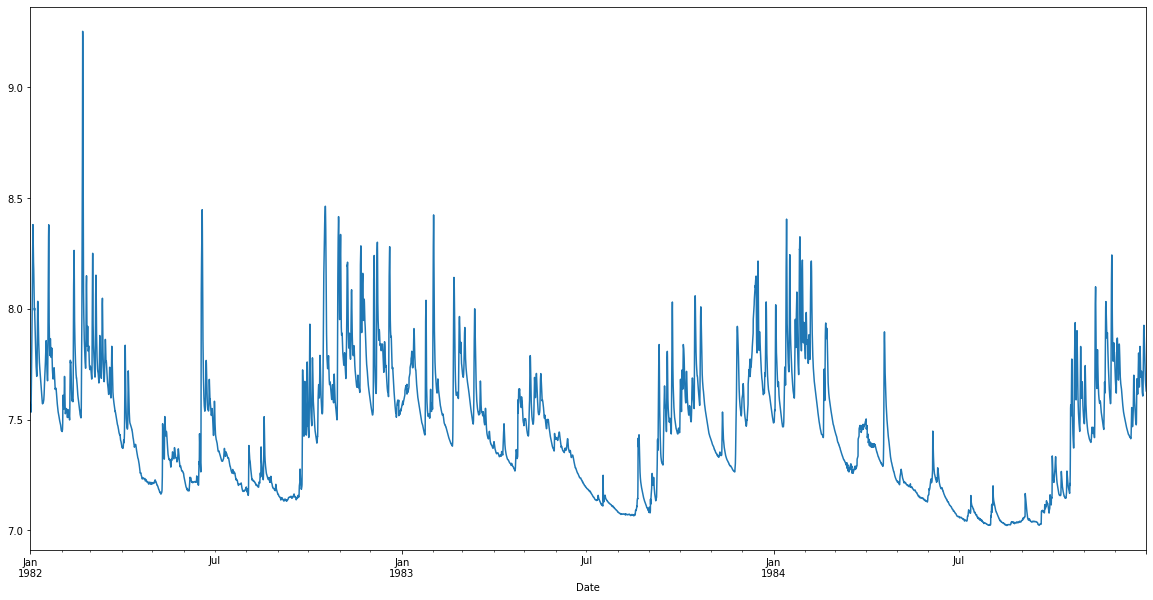

In [58]:




series_hourly_int['1982':'1984'].plot()

In [59]:







# ### Save the Interpolated series to file

In [ ]:




series_hourly_int.to_csv('processed_series.csv')